In [2]:
using Graphs
using RNAStructPlot
using LinearAlgebra

In [112]:
function rna_pairs(structure::String)
    opened = []
    pairs = []
    for (i,v) in enumerate(structure)
        if v == '('
            push!(opened, i)
        elseif v == ')'
            j = pop!(opened)
            push!(pairs, (j, i))
        end
    end
    #return merge(Dict(pairs), Dict([(j, i) for (i, j) in pairs]))
    return Dict(pairs)
end


function rna_tree(structure::String)
    graph = complete_graph(0)
    pairs = rna_pairs(structure)
    lastv(graph) = maximum(vertices(graph))
    edges_info = Dict()
    vertices_info = Dict()

    function rna_tree(first, last, attached, in_edge=[], in_vertex=[])
        add_vertex!(graph)
        base = lastv(graph)
        vertices_info[base] = in_vertex
        if !isnothing(attached)
            # add to neigbored vertex
            add_edge!(graph, attached, base)
            edges_info[(attached, base)] = in_edge
        end
        while first <= last
            # Walk along node
            if structure[first] == '.'
                push!(vertices_info[base], first)
                first += 1
            end
            # detect begin of region
            if haskey(pairs, first)
                rfirst = first
                rlast = pairs[rfirst]
                region_pairs = []
                # walk along region
                while structure[rfirst+1] == '(' && structure[rlast-1] == ')' && rfirst < rlast
                    rfirst += 1
                    rlast -= 1
                    push!(region_pairs, (rfirst, rlast))
                end
                region_out = [rfirst, rlast]
                # recusively go into subtree and add them to graph
                rna_tree(rfirst+1, rlast-1, base, region_pairs, region_out)
                
                #Append region pair to vertices_info
                push!(vertices_info[base], first, pairs[first])

                first = pairs[first]+1
            end
        end
        return graph, edges_info, vertices_info
    end

    return rna_tree(1, length(structure), nothing)
end

rna_tree (generic function with 1 method)

In [113]:
g, region, loops = rna_tree("...(((((((..((((((.........))))))......).((((((.......))))))..))))))...")

(SimpleGraph{Int64}(4, [[2], [1, 3, 5], [2, 4], [3], [2]]), Dict{Any, Any}((1, 2) => Any[(5, 67), (6, 66), (7, 65), (8, 64), (9, 63)], (2, 5) => Any[(43, 59), (44, 58), (45, 57), (46, 56), (47, 55)], (3, 4) => Any[(14, 32), (15, 31), (16, 30), (17, 29), (18, 28)], (2, 3) => Any[]), Dict{Any, Any}(5 => [47, 55, 48, 49, 50, 51, 52, 53, 54], 4 => [18, 28, 19, 20, 21, 22, 23, 24, 25, 26, 27], 2 => [9, 63, 10, 40, 41, 42, 60, 61, 62], 3 => [10, 40, 11, 12, 13, 33, 34, 35, 36, 37, 38, 39], 1 => Any[1, 2, 3, 4, 68, 69, 70, 71]))

In [108]:
using Graphs
using LinearAlgebra

function repulsive_force(pu, pv, c_rep=4.2)
    return (c_rep/norm(pv - pu)^2.0) * normalize(pu - pv)
end

function spring_force(pu, pv, c_spring=1.4, l = 3.0)
    return c_spring * log(norm(pv - pu)/l) * normalize(pv - pu)
end

function attractive_force(pu, pv)
    spring_force(pu, pv) - repulsive_force(pu, pv)
end


function displacement_vector(graph, u, p)
    displacement = [0.0 0.0]
    for v in vertices(graph)
        if u != v
            displacement += repulsive_force(p[u], p[v])
            if has_edge(graph, u, v)
                displacement += attractive_force(p[u], p[v])
            end
        end
    end
    return displacement
end

function initialize_p(g)
    return Dict( v => [cos((v-1)*2*pi/(nv(g)))  sin((v-1)*2*pi/(nv(g)))] .* rand(1,2) for v in range(1, nv(g)))
end

function delta(t)
    return 0.99^t
end

function gen_eades(graph, p, epsilon=0.01, t_max=100)
    forces = Dict(v => [epsilon epsilon] for v in vertices(graph))
    t = 1 #time
    # continue until time is up or forces are to weak 
    while t < t_max && maximum(map(norm, values(forces))) > epsilon
        for u in vertices(graph)
            forces[u] = displacement_vector(graph, u, p)
        end
        for u in vertices(graph)
            p[u] += delta(t) * forces[u]
        end
        t += 1
    end
    return p
end

gen_eades (generic function with 3 methods)

In [114]:
p = initialize_p(g)
gen_eades(g, p)

Dict{Int64, Matrix{Float64}} with 5 entries:
  5 => [2.57089 -3.66091]
  4 => [-5.78822 1.00312]
  2 => [1.29511 -0.38476]
  3 => [-2.45372 0.439696]
  1 => [4.03675 1.8419]

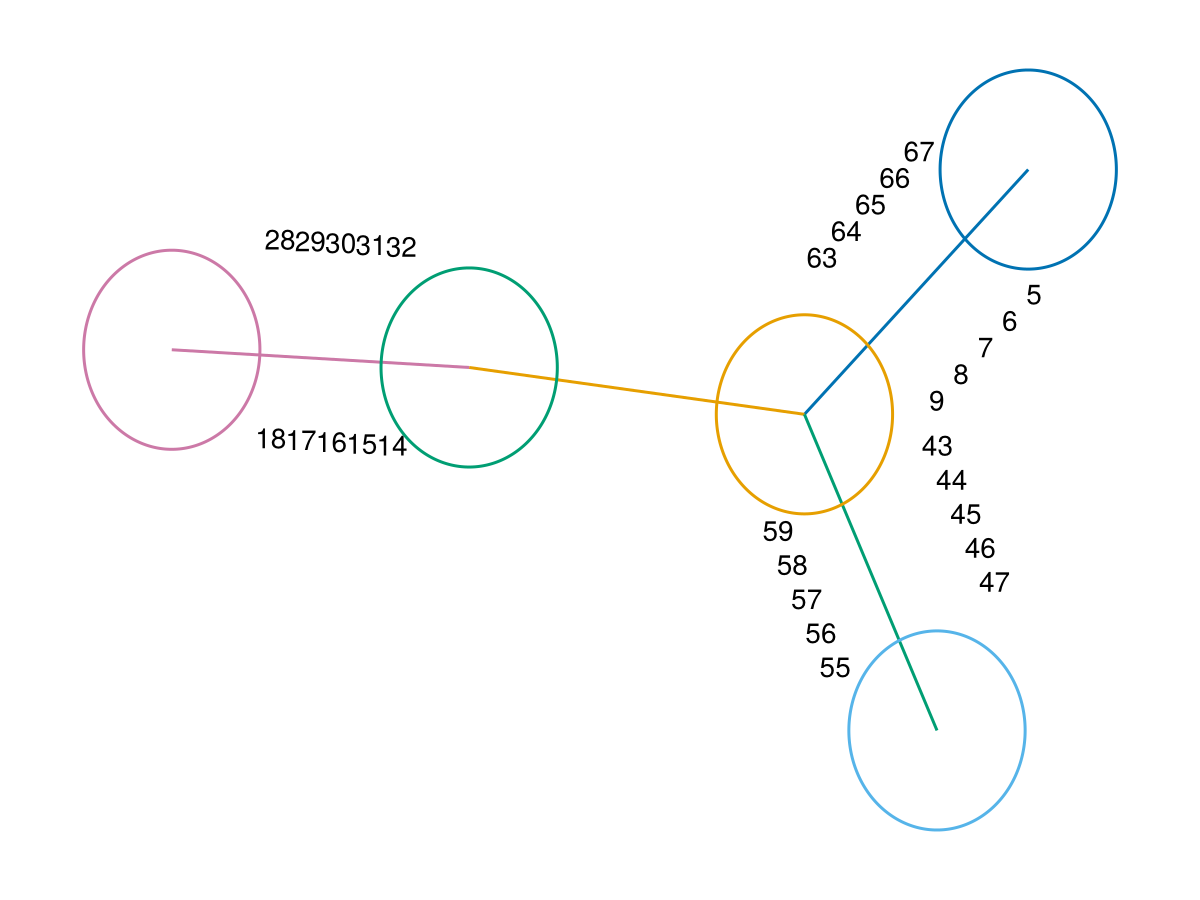

In [164]:
using CairoMakie
using Graphs
using LinearAlgebra

p = initialize_p(g)
gen_eades(g, p)

radius = 1

f = Figure()
ax = Axis(f[1,1])

for e in edges(g)
    s = srcx, srcy = p[src(e)]
    d = dstx, dsty = p[dst(e)]
    lines!([srcx, dstx], [srcy, dsty])

    f = fx, fy = normalize(d-s)
    r = rx, ry = [fy -fx]

    sn = srcx, srcy = s+f*radius
    dn = dstx, dsty = d-f*radius

    left(i, total) = sn + r + f * (norm(d-s)-2*radius) * ((i-1)/(total))
    right(i, total) = sn - r + f * (norm(d-s)-2*radius) * ((i-1)/(total))

    region_size = length(region)
    pairs = sort(region[(src(e), dst(e))];by=x->x[1])
    for (i, v) in enumerate(pairs)
        p1, p2 = v
        x, y = right(i, region_size)
        text!(x, y; text=string(p1))
        x, y = left(i, region_size)
        text!(x, y; text=string(p2))
    end
end

for v in vertices(g)
    size = length(loops[v])
    c = cx, cy = p[v]
    arc!(Point2f(cx, cy), radius, -π, π)
    for n in neighbors(g, v)
        n = nx, ny = p[n]
        dx, dy = direction = n-c
        rot = rx, ry = [dy, dx]*0.1
    end
end

#ax.aspect = 1
hidedecorations!(ax)
hidespines!(ax)

current_figure()